# Feature Engineering & Trend Analysis
-------------------

This notebook focuses on engineering features for categorical and time-series data, while also exploring trends and autocorrelations in the dataset.

Key Highlights:

1. Categorical Data: Features are engineered using embeddings generated by a large language model.
2. Time-Series Data: Cyclical encodings are applied to capture temporal patterns.
3. Trend Analysis: Visualization of trends and autocorrelations is included to examine data dynamics.
4. Data Integration: Merges data from multiple sources, such as crypto lending/borrowing rates, market prices, and U.S. bond yields, into a unified dataset for analysis.

This streamlined approach ensures the dataset is ready for advanced modeling and analysis.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

c:\Users\sghia\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
import mysql.connector
from mysql.connector import Error
import pandas as pd

# MySQL database connection function
def connect_to_database():
    try:
        # Establishing connection to the database
        connection = mysql.connector.connect(
            host='crypto-matter.c5eq66ogk1mf.eu-central-1.rds.amazonaws.com',
            database='Crypto',
            user='Jing',  # Replace with your actual first name
            password='Crypto12!'
        )

        if connection.is_connected():
            db_info = connection.get_server_info()
            print("Connected to MySQL database, MySQL Server version: ", db_info)
            return connection

    except Error as e:
        print("Error while connecting to MySQL", e)
        return None

# Function to query merged data from crypto_lending_borrowing and crypto_price tables
def query_merged_crypto_data(connection):
    query = """
    SELECT clb.lending_rate, clb.borrowing_rate, clb.utilization_rate, clb.stable_borrow_rate,
    cp.*, usb.yield
    FROM crypto_lending_borrowing clb
    JOIN crypto_price cp 
        ON clb.crypto_symbol = cp.crypto_symbol
        AND clb.date = cp.date
    LEFT JOIN US_Bond_Yield usb
        ON clb.date = usb.date
    WHERE UPPER(clb.crypto_symbol) IN ('1INCHUSDT', 'BALUSDT', 'BATUSDT', 'CRVUSDT', 'ENJUSDT', 'ENSUSDT', 'KNCUSDT', 'LINKUSDT', 'MANAUSDT', 'MKRUSDT', 'RENUSDT', 'SNXUSDT', 'UNIUSDT', 'WBTCUSDT', 'YFIUSDT', 'ZRXUSDT')
    """
    cursor = connection.cursor()

    try:
        # Execute the query
        cursor.execute(query)

        # Fetch all results
        results = cursor.fetchall()

        # Get column names from cursor description
        columns = [desc[0] for desc in cursor.description]

        # Convert results to a Pandas DataFrame
        df = pd.DataFrame(results, columns=columns)

        return df

    except Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()

# Function to close the database connection
def query_quit(connection):
    if connection.is_connected():
        connection.close()
        print("MySQL connection is closed")


connection = connect_to_database()

if connection:
    # Query merged data
    merged_df = query_merged_crypto_data(connection)

    if merged_df is not None and not merged_df.empty:
        # Display first few rows of the DataFrame
        print("\nMerged DataFrame:")
        print(merged_df.head())
    else:
        print("\nNo data found after merging.")

    # Close the connection
    query_quit(connection)

Connected to MySQL database, MySQL Server version:  8.0.39

Merged DataFrame:
  lending_rate borrowing_rate utilization_rate stable_borrow_rate  \
0   -50.000000     -50.000000       -50.000000           0.030000   
1   -50.000000     -50.000000       -50.000000           0.030000   
2   -50.000000     -50.000000         0.013598           0.030000   
3   -50.000000     -50.000000         0.014834           0.030000   
4   -50.000000     -50.000000         0.014834           0.030000   

  crypto_symbol                date  high   low close adj_close   volume  \
0       BATUSDT 2020-12-02 14:00:00  0.24  0.24  0.24      0.24  1294545   
1       BATUSDT 2020-12-02 15:00:00  0.24  0.24  0.24      0.24   936344   
2       BATUSDT 2020-12-02 16:00:00  0.24  0.24  0.24      0.24   724626   
3       BATUSDT 2020-12-02 17:00:00  0.24  0.24  0.24      0.24   710071   
4       BATUSDT 2020-12-02 18:00:00  0.25  0.24  0.24      0.24  1124485   

  market_cap coin_supply     yield  
0       None 

In [4]:
# converting US bond yield from hourly to yearly under continous compounding assumptions
merged_df['yield'] = np.exp(merged_df['yield']*365*24)-1

merged_df.head()

,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,crypto_symbol,date,high,low,close,adj_close,volume,market_cap,coin_supply,yield
0,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 14:00:00,0.24,0.24,0.24,0.24,1294545,None,None,0.008552840317602313182744400
1,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 15:00:00,0.24,0.24,0.24,0.24,936344,None,None,0.008552840317602313182744400
2,-50.000000,-50.000000,0.013598,0.030000,BATUSDT,2020-12-02 16:00:00,0.24,0.24,0.24,0.24,724626,None,None,0.008552840317602313182744400
3,-50.000000,-50.000000,0.014834,0.030000,BATUSDT,2020-12-02 17:00:00,0.24,0.24,0.24,0.24,710071,None,None,0.008552840317602313182744400
4,-50.000000,-50.000000,0.014834,0.030000,BATUSDT,2020-12-02 18:00:00,0.25,0.24,0.24,0.24,1124485,None,None,0.008552840317602313182744400


### LLM Embeddings

- Getting embeddings from a large language model based on the crypto symbol names
- These are high dimensional, in order to reduce dimensions we use PCA

In [11]:
def create_llm_embeddings(dataframe, col, n_components=10):
    model = SentenceTransformer('all-MiniLM-L6-v2')

    unique_values = dataframe[col].unique()
    
    # Get embeddings for the unique values
    embeddings = model.encode(unique_values, show_progress_bar=False)

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Create a DataFrame to hold the reduced embeddings
    reduced_embeddings_df = pd.DataFrame(reduced_embeddings, columns=[f'{col}_embedding_{i+1}' for i in range(n_components)])

    reduced_embeddings_df[col] = unique_values

    dataframe = dataframe.merge(reduced_embeddings_df, on=col, how='left')

    return dataframe

merged_df_emb = create_llm_embeddings(merged_df, "crypto_symbol", n_components=15)

print(merged_df_emb.info())

c:\Users\sghia\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487675 entries, 0 to 487674
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   lending_rate                487675 non-null  object        
 1   borrowing_rate              487675 non-null  object        
 2   utilization_rate            487675 non-null  object        
 3   stable_borrow_rate          487675 non-null  object        
 4   crypto_symbol               487675 non-null  object        
 5   date                        487675 non-null  datetime64[ns]
 6   high                        487675 non-null  object        
 7   low                         487675 non-null  object        
 8   close                       487675 non-null  object        
 9   adj_close                   487675 non-null  object        
 10  volume                      487675 non-null  int64         
 11  market_cap                  0 non-null 

PCA Components with respective variance explained:

- 1 = 10%
- 2 = 20%
- 3 = 30%
- 4 = 40%
- 5 = 45%
- 6 = 55%
- 7 = 60%
- 8 = 65%
- 9 = 75%
- 10 = 80%
- 11 = 85%
- 13 = 90%
- 14 = 95%
- 15 = 99%

### Converting date-time into cyclical encodings

- trying to capture any repeating or cyclical patterns in the data

In [12]:
def create_cyclical_encodings(df, date_col):
    
    days_in_month_dict = {
    1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30,
    7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}

    df["Year"] = df[date_col].dt.year
    df["Month"] = df[date_col].dt.month
    df["Day"] = df[date_col].dt.day
    df["Hour"] = df[date_col].dt.hour
    df["DayofWeek"] = df[date_col].dt.dayofweek

    # Vectorized leap year handling and days in month calculation
    leap_year_mask = (df['Year'] % 4 == 0) & ((df['Year'] % 100 != 0) | (df['Year'] % 400 == 0))
    df['days_in_month'] = df['Month'].map(days_in_month_dict)
    
    # Adjust February for leap years
    df.loc[leap_year_mask & (df['Month'] == 2), 'days_in_month'] = 29

    df["Month_Sine"] = np.sin(2* np.pi * df["Month"] / 12)
    df["Month_Cosine"] = np.cos(2* np.pi * df["Month"] / 12)
    
    df["Day_Sine"] = np.sin(2* np.pi * df["Day"] / df['days_in_month'])
    df["Day_Cosine"] = np.cos(2* np.pi * df["Day"] / df['days_in_month'])
    
    df["Hour_Sine"] = np.sin(2* np.pi * df["Hour"] / 24)
    df["Hour_Cosine"] = np.cos(2* np.pi * df["Hour"] / 24)
    
    df["DayofWeek_Sine"] = np.sin(2* np.pi * df["DayofWeek"] / 7)
    df["DayofWeek_Cosine"] = np.cos(2* np.pi * df["DayofWeek"] / 7)

    df.drop(columns=["Month", "Day", "days_in_month", "Hour", "DayofWeek", "Year"], inplace=True)

    return df

merged_df_emb = create_cyclical_encodings(merged_df_emb, "date")

merged_df_emb.head()

,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,crypto_symbol,date,high,low,close,adj_close,...,crypto_symbol_embedding_14,crypto_symbol_embedding_15,Month_Sine,Month_Cosine,Day_Sine,Day_Cosine,Hour_Sine,Hour_Cosine,DayofWeek_Sine,DayofWeek_Cosine
0,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 14:00:00,0.24,0.24,0.24,0.24,...,0.169496,0.142061,-2.449294e-16,1.0,0.394356,0.918958,-0.500000,-8.660254e-01,0.974928,-0.222521
1,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 15:00:00,0.24,0.24,0.24,0.24,...,0.169496,0.142061,-2.449294e-16,1.0,0.394356,0.918958,-0.707107,-7.071068e-01,0.974928,-0.222521
2,-50.000000,-50.000000,0.013598,0.030000,BATUSDT,2020-12-02 16:00:00,0.24,0.24,0.24,0.24,...,0.169496,0.142061,-2.449294e-16,1.0,0.394356,0.918958,-0.866025,-5.000000e-01,0.974928,-0.222521
3,-50.000000,-50.000000,0.014834,0.030000,BATUSDT,2020-12-02 17:00:00,0.24,0.24,0.24,0.24,...,0.169496,0.142061,-2.449294e-16,1.0,0.394356,0.918958,-0.965926,-2.588190e-01,0.974928,-0.222521
4,-50.000000,-50.000000,0.014834,0.030000,BATUSDT,2020-12-02 18:00:00,0.25,0.24,0.24,0.24,...,0.169496,0.142061,-2.449294e-16,1.0,0.394356,0.918958,-1.000000,-1.836970e-16,0.974928,-0.222521


### Investigating Autocorrelations

1285
672


<Figure size 1000x600 with 0 Axes>

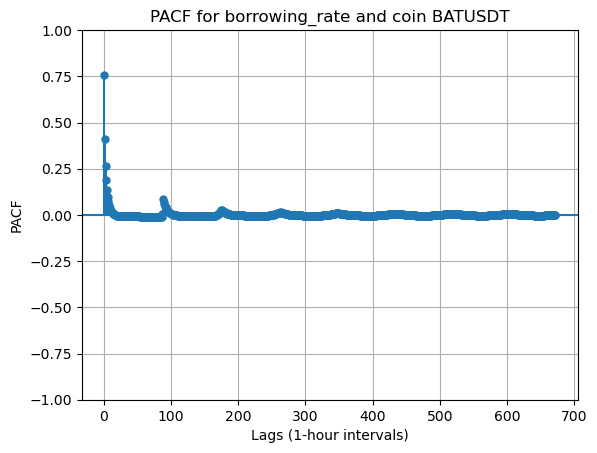

740
672


<Figure size 1000x600 with 0 Axes>

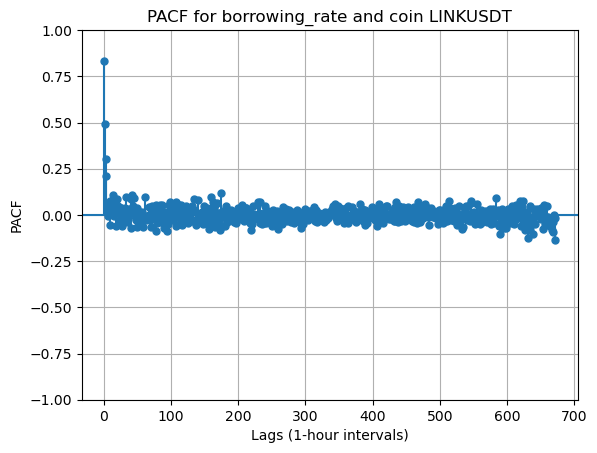

3369
672


<Figure size 1000x600 with 0 Axes>

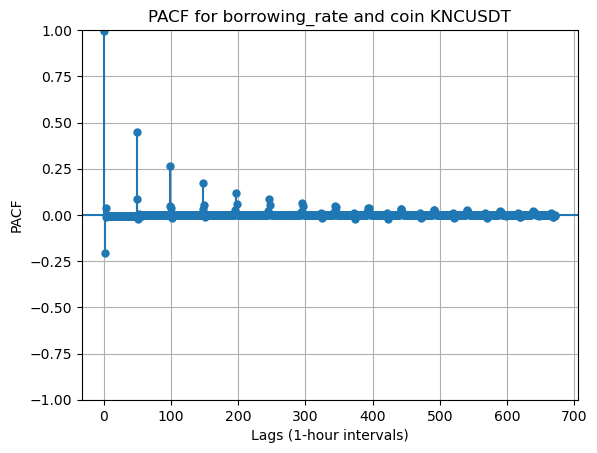

529
529


<Figure size 1000x600 with 0 Axes>

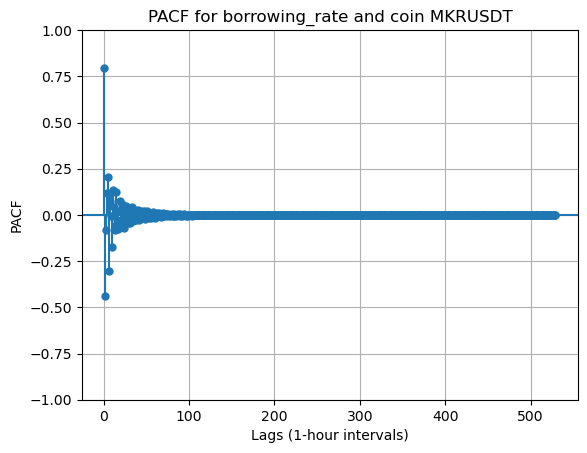

473
473


<Figure size 1000x600 with 0 Axes>

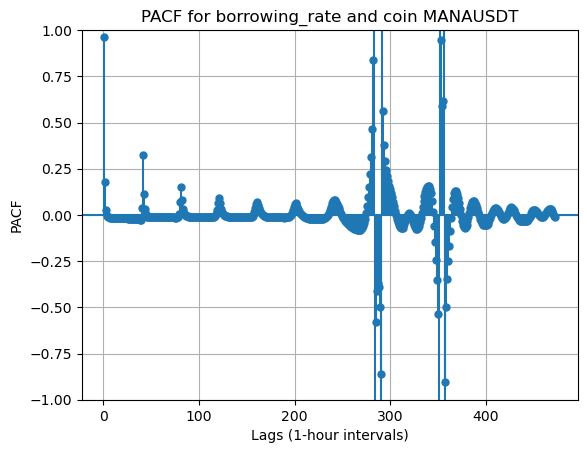

1222
672


<Figure size 1000x600 with 0 Axes>

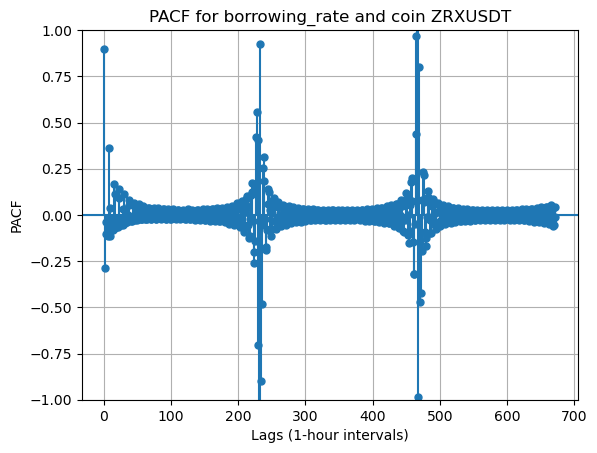

419
419


<Figure size 1000x600 with 0 Axes>

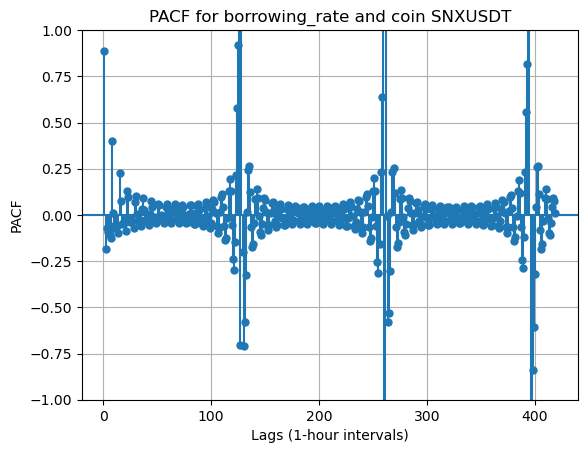

143
143


<Figure size 1000x600 with 0 Axes>

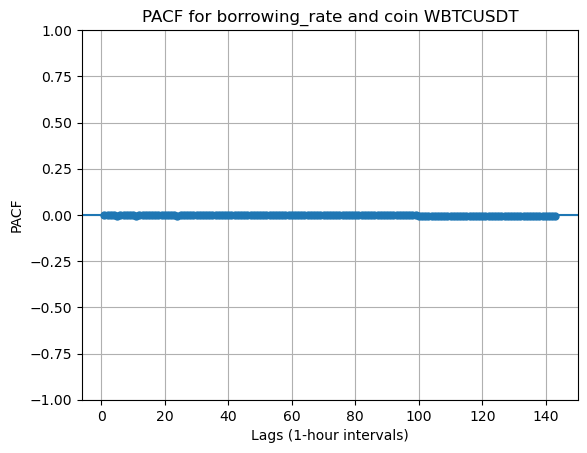

545
545


<Figure size 1000x600 with 0 Axes>

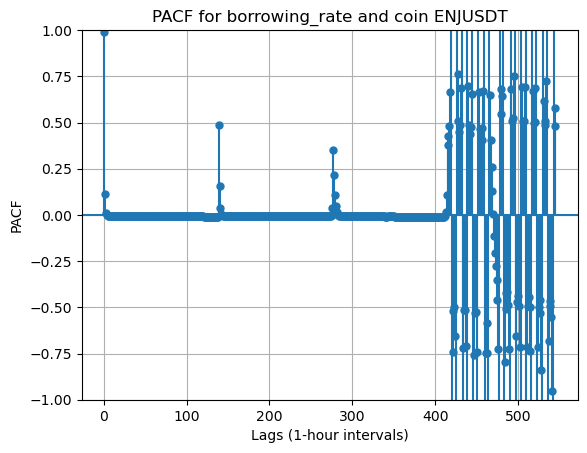

811
672


<Figure size 1000x600 with 0 Axes>

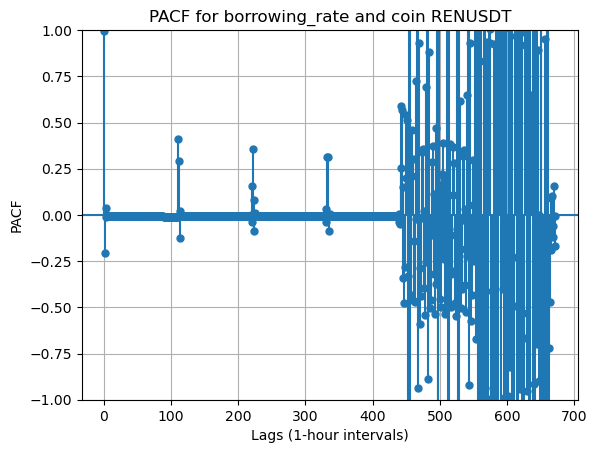

1613
672


<Figure size 1000x600 with 0 Axes>

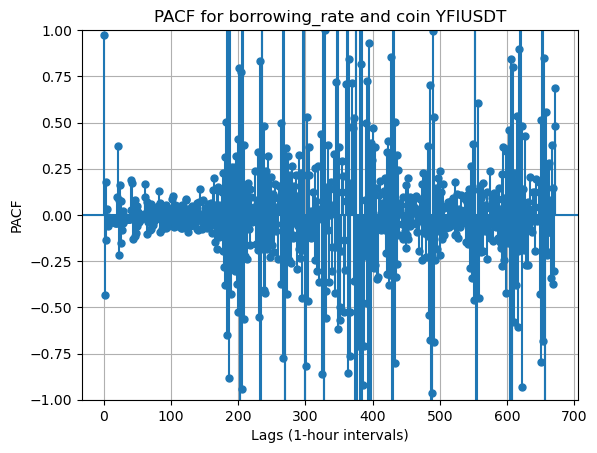

333
333


<Figure size 1000x600 with 0 Axes>

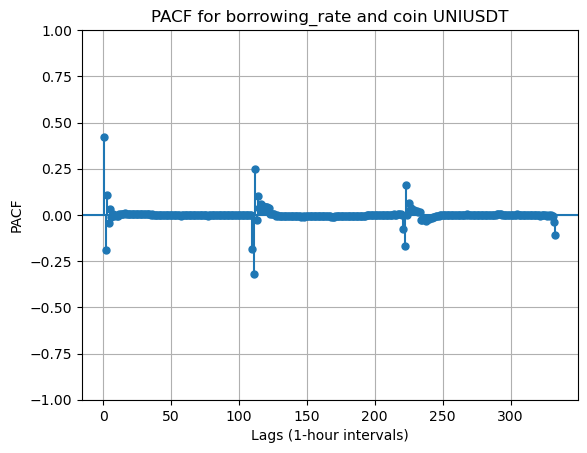

232
232


<Figure size 1000x600 with 0 Axes>

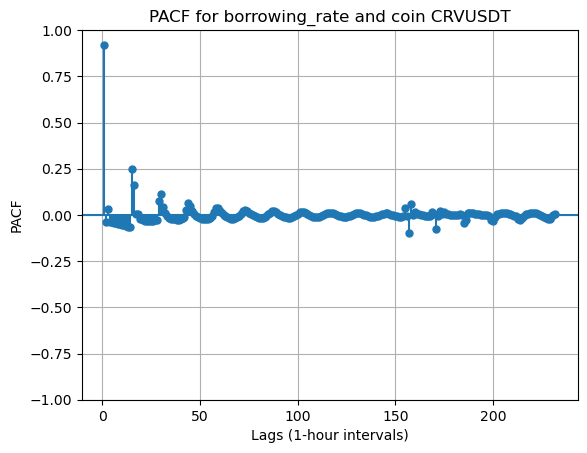

536
536


<Figure size 1000x600 with 0 Axes>

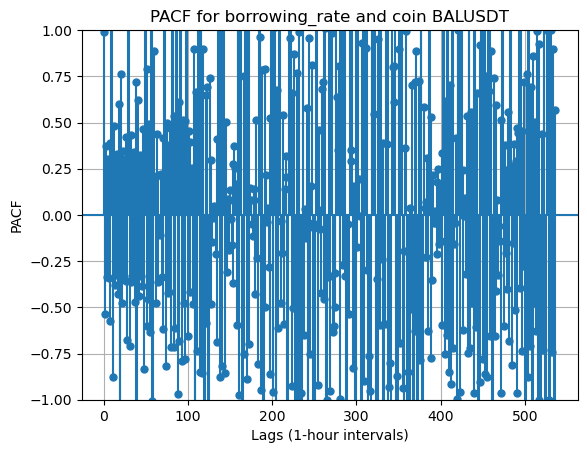

1642
672


<Figure size 1000x600 with 0 Axes>

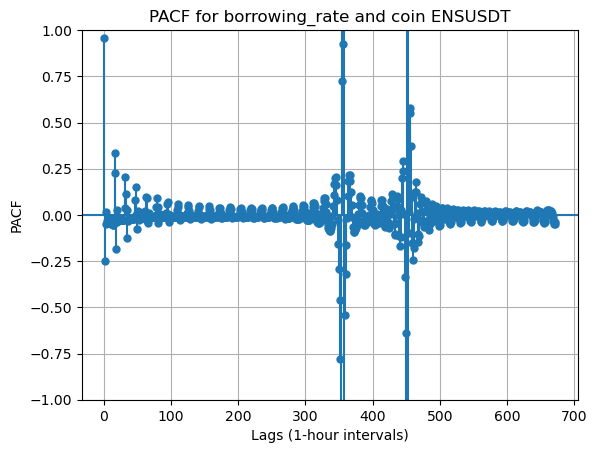

849
672


<Figure size 1000x600 with 0 Axes>

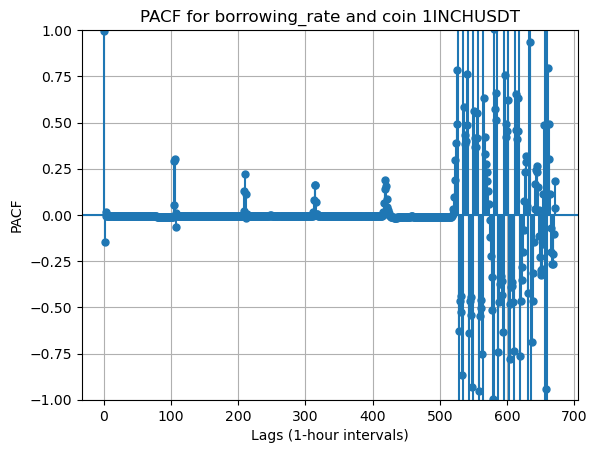

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

unique_coins = merged_df_emb["crypto_symbol"].unique()

for s in unique_coins:
    symbol_df = merged_df_emb[merged_df_emb["crypto_symbol"]==s]

    
    Ar_list = symbol_df["borrowing_rate"]

    # Step 1: Replace -50 with NaN (masking)
    Ar_list = Ar_list.replace(-50, np.nan)
    
    # Step 2: Find the longest consecutive non-NaN series
    longest_series_start = 0
    longest_series_end = 0
    longest_series_len = 0

    current_start = 0
    current_len = 0

    for i in range(len(Ar_list)):
        if pd.notna(Ar_list.iloc[i]):
            if current_len == 0:
                current_start = i
            current_len += 1
        else:
            if current_len > longest_series_len:
                longest_series_start = current_start
                longest_series_end = i
                longest_series_len = current_len
            current_len = 0

    # Check if the longest series ends at the last index
    if current_len > longest_series_len:
        longest_series_start = current_start
        longest_series_end = len(Ar_list)
        longest_series_len = current_len
    
    # Step 3: Extract the longest consecutive series
    longest_series = Ar_list.iloc[longest_series_start:longest_series_end]

    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()

    longest_series_standard = scaler.fit_transform(longest_series.values.reshape(-1, 1)).flatten()

    minimum = len(longest_series)//2 - 1

    lags = min(minimum,672)
    
    print(minimum)
    print(lags)
    
    plt.figure(figsize=(10, 6))
    plot_pacf(longest_series_standard, lags=lags, zero=False, method='ywadjusted', alpha=None)
    plt.title(f'PACF for borrowing_rate and coin {s}')
    plt.xlabel('Lags (1-hour intervals)')
    plt.ylabel('PACF')
    plt.grid()
    plt.show()

Different Coins seem to exhibit different patterns

### Checking Seasonality via Trend Anyalsis of Borrowing Rate

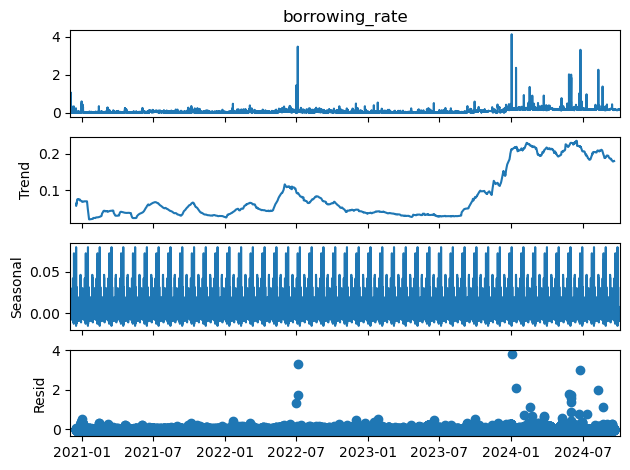

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
df = merged_df.copy()

# avoiding masked values

df["borrowing_rate"] = df["borrowing_rate"].apply(lambda x: -50 if x == 0 else x)

df["close"] = df["close"].apply(lambda x: 0 if x == -50 else x)

df["borrowing_rate"] = df["borrowing_rate"].apply(lambda x: None if x == -50 else x)

df["close"] = df["close"].apply(lambda x: None if x == -50 else x)

# Aggregate utilization_rate across distinct crypto symbols at every timestamp
df_mean_utilization = df.groupby('date')["borrowing_rate"].mean().dropna().reset_index()

df_mean_utilization.set_index("date", inplace=True)

period = 24*30  # Set this to a reasonable assumption about daily hourly cycles
analysis = seasonal_decompose(df_mean_utilization['borrowing_rate'].dropna(), period=period)


# Plot the decomposition
analysis.plot()
plt.show()

In [4]:
print(df["borrowing_rate"].mean())
print(df["borrowing_rate"].max())

0.0871083560029433
55.626264


<Figure size 1000x600 with 0 Axes>

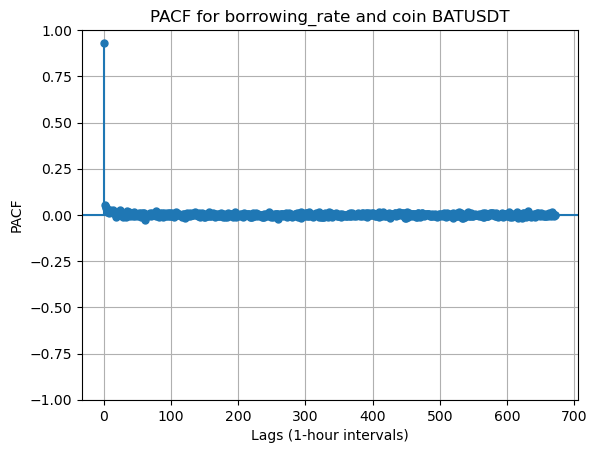

<Figure size 1000x600 with 0 Axes>

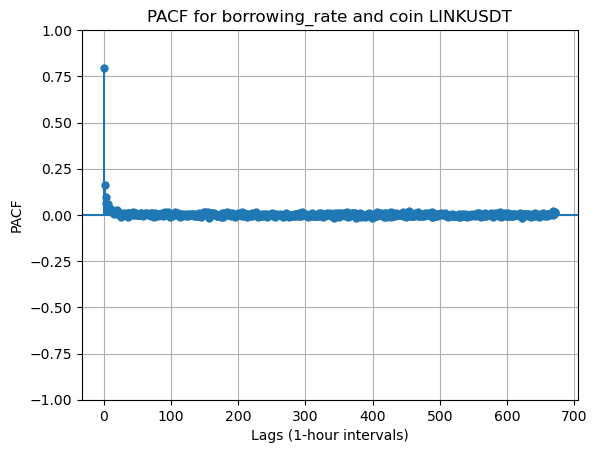

<Figure size 1000x600 with 0 Axes>

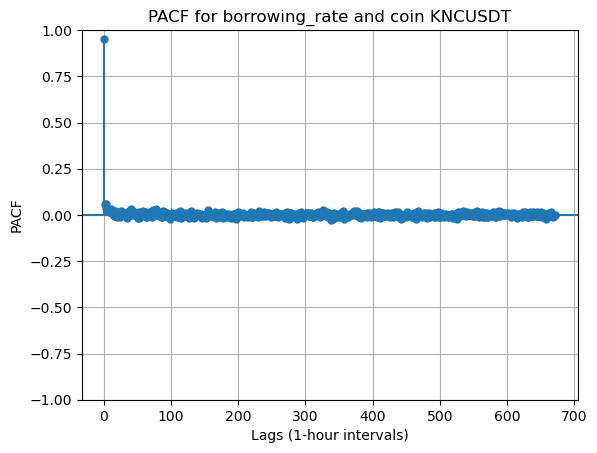

<Figure size 1000x600 with 0 Axes>

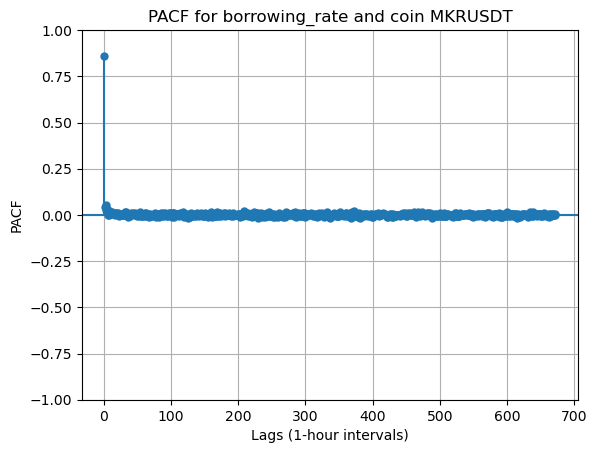

<Figure size 1000x600 with 0 Axes>

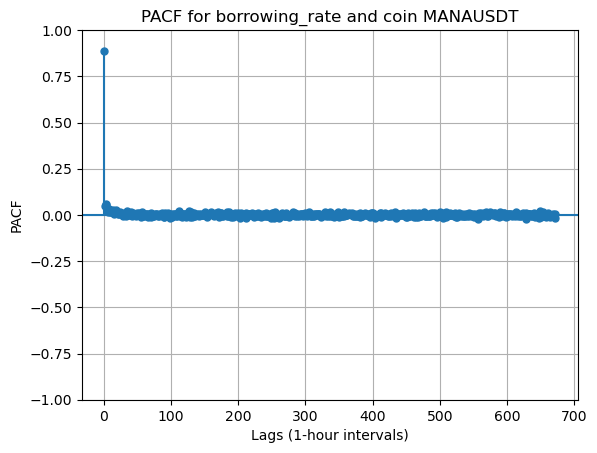

<Figure size 1000x600 with 0 Axes>

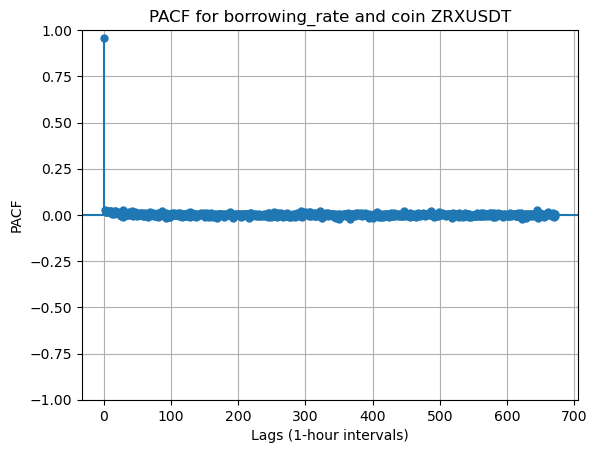

<Figure size 1000x600 with 0 Axes>

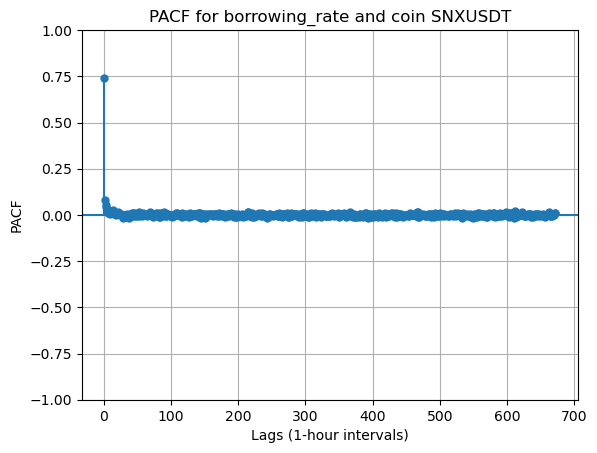

<Figure size 1000x600 with 0 Axes>

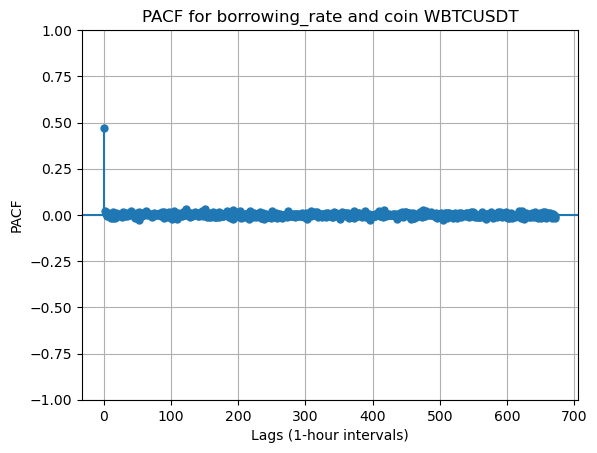

<Figure size 1000x600 with 0 Axes>

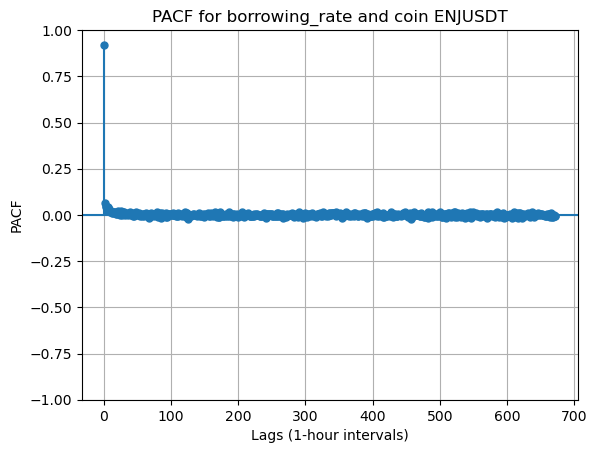

<Figure size 1000x600 with 0 Axes>

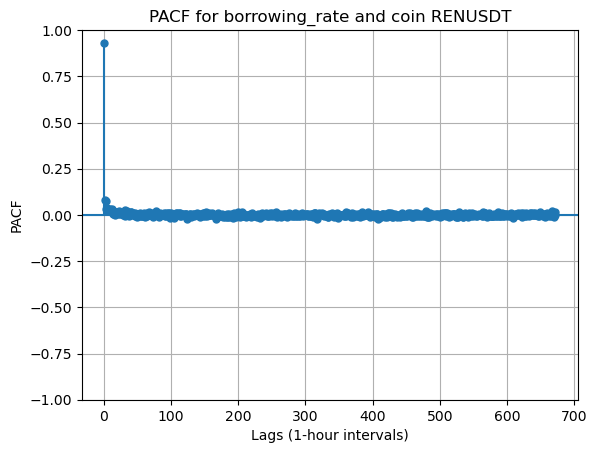

<Figure size 1000x600 with 0 Axes>

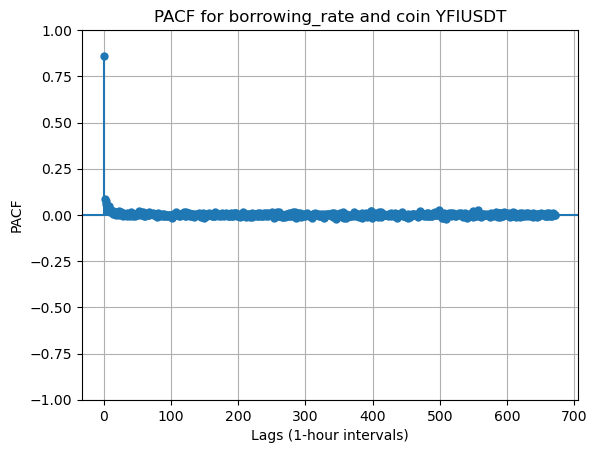

<Figure size 1000x600 with 0 Axes>

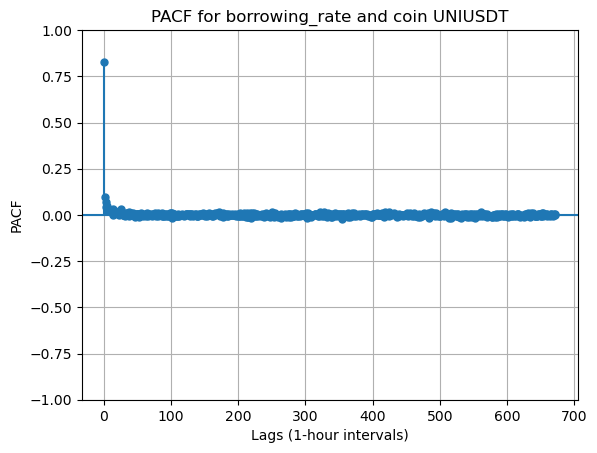

<Figure size 1000x600 with 0 Axes>

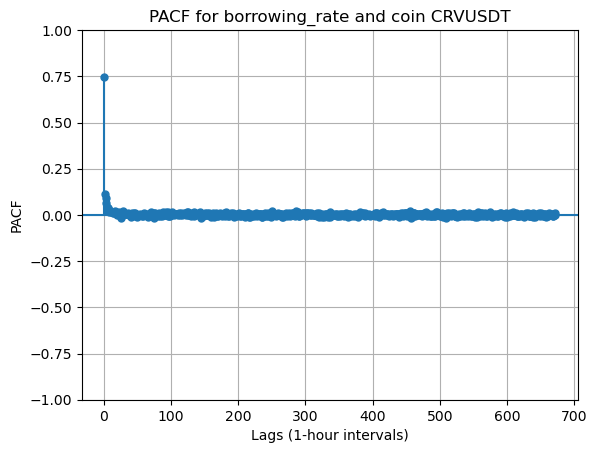

<Figure size 1000x600 with 0 Axes>

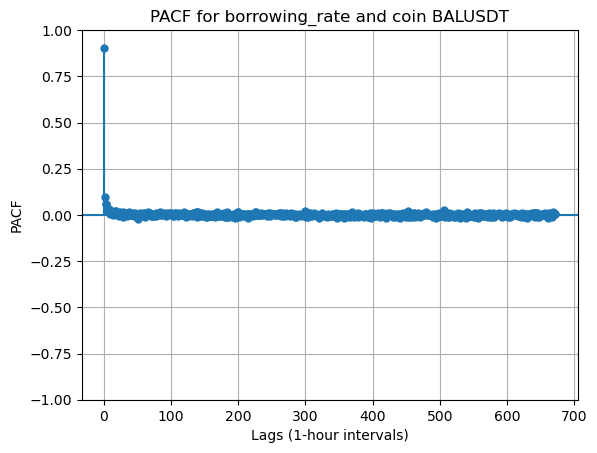

<Figure size 1000x600 with 0 Axes>

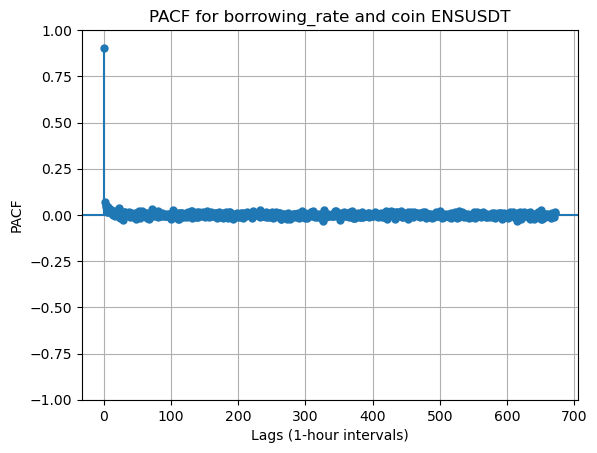

<Figure size 1000x600 with 0 Axes>

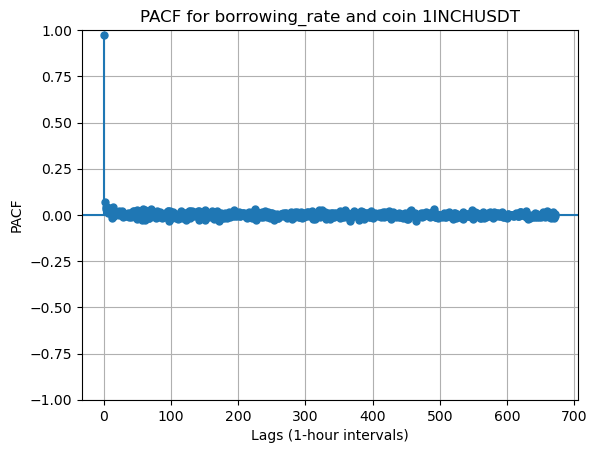

In [22]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

lags = 672

unique_coins = merged_df["crypto_symbol"].unique()

for s in unique_coins:
    symbol_df = merged_df[merged_df["crypto_symbol"]==s]
    plt.figure(figsize=(10, 6))
    plot_pacf(symbol_df['borrowing_rate'].dropna(), lags=lags, zero=False, method='ywadjusted', alpha=None)
    plt.title(f'PACF for borrowing_rate and coin {s}')
    plt.xlabel('Lags (1-hour intervals)')
    plt.ylabel('PACF')
    plt.grid()
    plt.show()

There seem to be on average weak cyclical trends across all coins